Import the dataset

In [6]:
import pandas as pd

df = pd.read_csv('Ecommerce_Delivery_Analytics_New.csv')

In [7]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ","_")

In [8]:
df.drop(columns=['order_date_&_time'])


,order_id,customer_id,platform,delivery_time_(minutes),product_category,order_value_(inr),customer_feedback,service_rating,delivery_delay,refund_requested
0,ORD000001,CUST2824,JioMart,30,Fruits & Vegetables,382,"Fast delivery, great service!",5,No,No
1,ORD000002,CUST1409,Blinkit,16,Dairy,279,Quick and reliable!,5,No,No
2,ORD000003,CUST5506,JioMart,25,Beverages,599,Items missing from order.,2,No,Yes
3,ORD000004,CUST5012,JioMart,42,Beverages,946,Items missing from order.,2,Yes,Yes
4,ORD000005,CUST4657,Blinkit,30,Beverages,334,"Fast delivery, great service!",5,No,No
...,...,...,...,...,...,...,...,...,...,...
99995,ORD099996,CUST5324,JioMart,24,Dairy,289,Packaging could be better.,3,No,No
99996,ORD099997,CUST1677,JioMart,19,Snacks,322,Good quality products.,4,No,No
99997,ORD099998,CUST8198,JioMart,41,Dairy,135,"Fast delivery, great service!",5,Yes,No
99998,ORD099999,CUST9975,JioMart,31,Grocery,973,Quick and reliable!,5,No,No


In [9]:
# What percentage of customers place repeat orders?
count = df['customer_id'].value_counts()[df['customer_id'].value_counts() > 1].count()
print((count/len(df))*100)

9.0


In [10]:
# What is the average order value per customer?
customers = df.groupby('customer_id')
customers['order_value_(inr)'].mean()

customer_id
CUST1000    544.900000
CUST1001    551.647059
CUST1002    563.666667
CUST1003    596.714286
CUST1004    614.818182
               ...    
CUST9995    683.111111
CUST9996    610.363636
CUST9997    486.000000
CUST9998    581.714286
CUST9999    676.727273
Name: order_value_(inr), Length: 9000, dtype: float64

In [11]:
# What is the average delivery time per product category?
average_delivery_time = df.groupby('product_category')['delivery_time_(minutes)'].mean()
average_delivery_time

product_category
Beverages              29.503568
Dairy                  29.560657
Fruits & Vegetables    29.551467
Grocery                29.580689
Personal Care          29.571584
Snacks                 29.448668
Name: delivery_time_(minutes), dtype: float64

In [12]:
# Which platform generates the most revenue?
platform_sales = df.groupby('platform')['order_value_(inr)'].sum()
platform_sales

platform
Blinkit             19705084
JioMart             19562372
Swiggy Instamart    19831984
Name: order_value_(inr), dtype: int64

In [13]:
# Which product categories contribute the most to overall revenue?
overall_revenue = df['order_value_(inr)'].sum()
product_category_revenue = df.groupby('product_category')['order_value_(inr)'].sum()
print((product_category_revenue/overall_revenue)*100)

product_category
Beverages              15.375220
Dairy                  12.877486
Fruits & Vegetables    10.569503
Grocery                24.017241
Personal Care          29.434460
Snacks                  7.726090
Name: order_value_(inr), dtype: float64


In [14]:
df['negative']= df['service_rating'] <= 2

In [15]:
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Add contextual stopwords
contextual_stopwords = ['delivery', 'delivered', 'item','items','package','product', 'order','person']
stop_words.update(contextual_stopwords)
all_words = []

for text in df[df['negative'] == True]['customer_feedback'].dropna():
    words = word_tokenize(re.sub(r'[^\w\s]', '', text.lower()))
    all_words.extend([word for word in words if word not in stop_words])

word_counts = Counter(all_words)
print(word_counts.most_common(10))

[('wrong', 7738), ('missing', 7737), ('rude', 7643), ('late', 7592), ('happy', 7592), ('fresh', 7580), ('disappointed', 7580), ('horrible', 7529), ('experience', 7529), ('never', 7529)]


In [16]:
low_rating_refunds = df[(df['service_rating'] <= 2) & (df['refund_requested'] == 'Yes')]
total_low_ratings = df[df['service_rating'] <= 2]['service_rating'].count()
print((len(low_rating_refunds)/total_low_ratings)*100)


100.0


In [17]:
# What is the correlation between order value and service rating?
from scipy.stats import kendalltau, spearmanr

corr, p_value = kendalltau(df['order_value_(inr)'], df['service_rating'])
print(f"Kendall's Tau: {corr}, p-value: {p_value}")


corr_, p_value_ = spearmanr(df['order_value_(inr)'], df['service_rating'])
print(f"Spearman Correlation: {corr_}, p-value: {p_value_}")

Kendall's Tau: -0.0015920381955643495, p-value: 0.5012442855867177
Spearman Correlation: -0.0021272223419577688, p-value: 0.5011514531811885


           platform  service_rating  delivery_time_(minutes)  rating_z  \
2  Swiggy Instamart        3.243415                29.499925  0.525687   
0           Blinkit        3.233844                29.474898 -1.399831   
1           JioMart        3.245147                29.634498  0.874144   

   delivery_time_z  balance_score  
2        -0.521007       1.046694  
0        -0.878098      -0.521732  
1         1.399105      -0.524962  


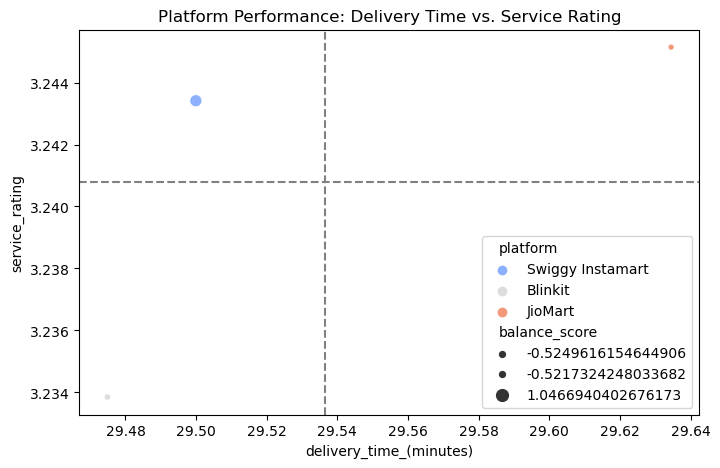

In [18]:
# Which platform has the best/worst balance between delivery speed and service rating?
from scipy.stats import zscore

df_grouped = df.groupby('platform').agg({
    'service_rating': 'mean',
    'delivery_time_(minutes)': 'mean'
}).reset_index()

df_grouped['rating_z'] = zscore(df_grouped['service_rating'])
df_grouped['delivery_time_z'] = zscore(df_grouped['delivery_time_(minutes)'])

df_grouped['balance_score'] = df_grouped['rating_z'] - df_grouped['delivery_time_z']
df_grouped = df_grouped.sort_values(by='balance_score', ascending=False)
print(df_grouped)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_grouped, x='delivery_time_(minutes)', y='service_rating', hue='platform', size='balance_score', palette='coolwarm', legend=True)
plt.axhline(df_grouped['service_rating'].mean(), color='gray', linestyle='dashed')
plt.axvline(df_grouped['delivery_time_(minutes)'].mean(), color='gray', linestyle='dashed')
plt.title("Platform Performance: Delivery Time vs. Service Rating")
plt.show()


In [19]:
df_grouped = df.groupby('platform').agg({
    'delivery_time_(minutes)': 'mean',
    'service_rating': 'mean'
}).reset_index()

df_grouped['balance_score'] = df_grouped['service_rating'] / df_grouped['delivery_time_(minutes)']
df_grouped = df_grouped.sort_values(by='balance_score', ascending=False)
print(df_grouped)

           platform  delivery_time_(minutes)  service_rating  balance_score
2  Swiggy Instamart                29.499925        3.243415       0.109947
0           Blinkit                29.474898        3.233844       0.109715
1           JioMart                29.634498        3.245147       0.109506
